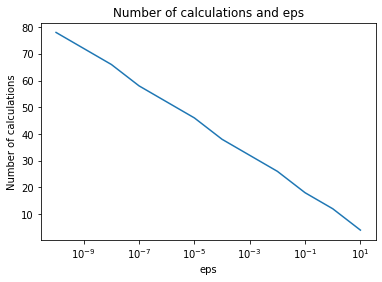

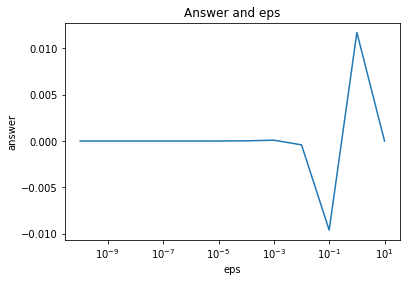

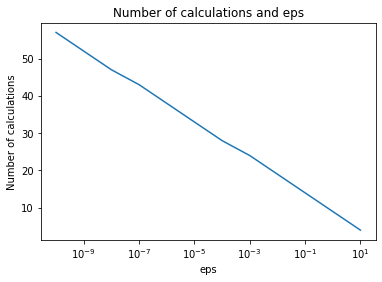

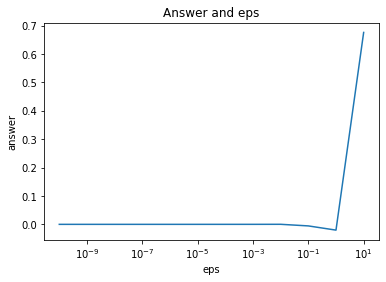

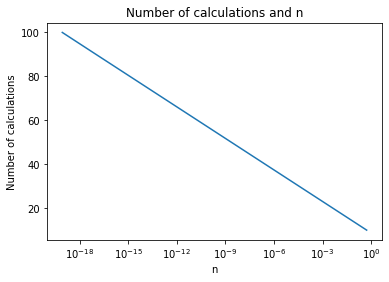

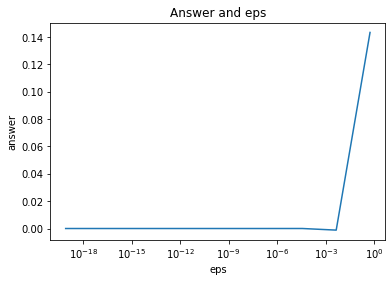

In [1]:
from typing import Callable, Tuple
import numpy as np
%run ../lab1/one_dimensional.ipynb
import datetime
import plotly.graph_objects as go

In [2]:
def search_range_with_min(f: Callable, x0: float, step=0.1, eps=1e-6) -> Tuple[float, float]:
    if f(x0) < f(x0 + step):
        x0 += step
        step *= -1

    y0 = f(x0)
    x = x0 + step

    while f(x) < y0 + eps:
        step *= 2
        x += step

    if step > 0:
        return x0, x
    return x, x0


In [3]:
def calculate_step(f: Callable, x: float, grad: float, method, arg):
    step_f = lambda step: f(x + step * grad)
    left, right = search_range_with_min(step_f, 0)
    arg, _ = method(step_f, left, right, arg)
    return arg


In [4]:
def gradient_descent(f: Callable, f_grad: Callable, x0,  method, arg, eps=10**-10, max_iter=1e5):
    x = x0

    it = 0
    trace = [x]
    while True:
        grad = -f_grad(x)

        step = calculate_step(f, x, grad, method, arg)
        next_x = x + step * grad
        trace.append(next_x)
        if abs(f(next_x) - f(x)) < eps or np.linalg.norm(grad) < eps or it >= max_iter:
            return next_x, trace

        x = next_x
        it += 1


In [5]:
def measure(f, *args):
    start_time = datetime.datetime.now()
    res, _ = f(*args)
    end_time = datetime.datetime.now()
    return res, 'Microseconds ' + str((end_time-start_time).microseconds)

In [6]:
def test_f(arg):
    return arg[0] ** 2 + (arg[1] - 1) ** 2

def test_f_grad(arg):
    return np.array([arg[0] * 2, arg[1] * 2 - 2])

print(measure(gradient_descent, test_f, test_f_grad, np.array([-10, 15]), dihotomi, 10**-4))
print(measure(gradient_descent, test_f, test_f_grad, np.array([-10, 15]), gold_sech, 10**-4))
print(measure(gradient_descent, test_f, test_f_grad, np.array([-10, 15]), fibbonachi, 17))

(array([-2.48392357e-16,  1.00000000e+00]), 'Microseconds 670')
(array([1.8621445e-14, 1.0000000e+00]), 'Microseconds 811')
(array([1.28493858e-07, 9.99999820e-01]), 'Microseconds 488')


In [7]:
def analyze(f, f_grad, x_border, y_border, method, param):
    x = np.linspace(x_border[0], x_border[1], 50)
    y = np.linspace(y_border[0], y_border[1], 50)
    z = np.vectorize(lambda x, y: f(np.array([x, y])))(*np.meshgrid(x, y))

    fig = go.Figure()
    fig.add_trace(
        go.Contour(
            x=x, y=y,
            z=z,
            contours_coloring='lines',
            line_width=2
        ))
    
    _, trace = gradient_descent(
        f, f_grad,
        np.array([-3, -3]),
        method,
        param
    )
    
    xy = trace
    print(trace[-5:])
    
    print(f'step count = {len(xy)}')
    fig.add_trace(
        go.Scatter(
            x=[p[0] for p in xy], 
            y=[p[1] for p in xy],
        )
    )
    
    fig.show()

In [8]:
analyze(test_f, test_f_grad, np.array([-3,3]), np.array([-3,3]), dihotomi, 10**-4)

[array([-3, -3]), array([4.22515869e-06, 1.00000563e+00]), array([9.41575961e-13, 1.00000000e+00])]
step count = 3


In [9]:
def rosenbrock_f(arg):
    x = arg[0]
    y = arg[1]
    return 100 * ((y - x ** 2) ** 2) + ((1. - x) ** 2)

def rosenbrock_grad(arg):
    x = arg[0]
    y = arg[1]
    dx = 2 * (200 * (x ** 3) - 200 * x * y + x - 1)
    dy = 200 * (y - (x ** 2))
    return np.array([dx, dy])

analyze(rosenbrock_f, rosenbrock_grad, np.array([-10,20]), np.array([-10,20]), gold_sech, 10**-6)

[array([0.99978923, 0.99957743]), array([0.9997892 , 0.99957837]), array([0.99978971, 0.99957839]), array([0.99978967, 0.99957932]), array([0.99979018, 0.99957934])]
step count = 56866


In [10]:
import numpy as np
from random import uniform
from functools import partial


def generate_eigenvalues(n, k):
    eigenvalues = [1, k]
    for i in range(0, n - 2):
        eigenvalues.append(uniform(1, k))
    return eigenvalues


def generate_orthonormal_matrix(n):
    mx = []
    for i in range(0, n):
        mx.append([])
    for i in range(0, n):
        for j in range(0, n):
            mx[i].append(uniform(-100, 100))
    q, r = np.linalg.qr(mx)
    return q


def generate_hessian(n, k):
    eigenvalues = generate_eigenvalues(n, k)
    D = np.diag(eigenvalues)
    A = generate_orthonormal_matrix(n)
    H = np.matmul(np.matmul(A, D), np.transpose(A))
    return H


def fn_from_hessian(hessian, n):
    def fn(x):
        result = 0
        for i in range(0, n):
            for j in range(i, n):
                result = result + hessian[i][j] * x[i] * x[j]
        return result

    return fn


def grad_from_hessian(hessian, n):
    result = []

    def gr(it, x):
        return sum(np.array(x) * np.array(hessian[it]) * [2 if j == it else 1 for j in range(n)])

    for i in range(n):
        result.append(partial(gr, i))
    return result


def gen_fs(n, k):
    hess = generate_hessian(n, k)
    grad = grad_from_hessian(hess, n)
    return fn_from_hessian(hess, n), lambda x: np.array([gr(x) for gr in grad])

n = 5  k =  1 res =  [6.51166571e-16 6.51166577e-16 6.51166584e-16 6.51166571e-16
 6.51166577e-16]  iters =  3
n = 5  k =  2 res =  [-1.26797137e-07 -1.85653239e-07 -1.80406758e-07  2.86318655e-07
 -2.31104043e-07]  iters =  12
n = 5  k =  3 res =  [-3.26459447e-07 -1.68725858e-06  1.96120310e-07 -7.01502117e-07
 -4.49932517e-07]  iters =  15
n = 5  k =  4 res =  [ 1.09842974e-06 -5.28364902e-07 -1.27679930e-06 -5.50716350e-07
  9.13845458e-07]  iters =  14
n = 5  k =  5 res =  [-6.59547027e-07  2.30649116e-07 -5.89714415e-07 -8.70095003e-08
 -4.03227761e-07]  iters =  15
n = 5  k =  6 res =  [-1.40140072e-06 -5.26005117e-07  2.11810865e-07  4.42828735e-07
 -2.92333717e-06]  iters =  22
n = 5  k =  7 res =  [ 2.96948982e-07 -9.14438381e-07 -3.85149498e-06  5.97088223e-07
 -9.09977821e-07]  iters =  27
n = 5  k =  8 res =  [-2.48369903e-06  9.82594163e-07 -9.76821176e-08  1.46121090e-07
  4.39270344e-07]  iters =  22
n = 5  k =  9 res =  [ 7.87915555e-07 -3.43810086e-06  1.00157991e-06 

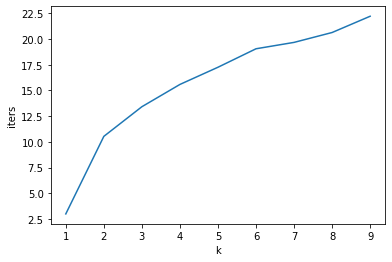

n = 2  k =  5 res =  [-1.26357804e-06  1.10319394e-07]  iters =  14
n = 3  k =  5 res =  [-2.00238491e-06 -9.67807812e-07 -1.45207013e-07]  iters =  15
n = 4  k =  5 res =  [-4.93651003e-06  6.60457822e-07  6.19622140e-07  2.54976627e-07]  iters =  26
n = 5  k =  5 res =  [-2.60842208e-07  7.35313539e-07 -1.40275540e-07  1.66157385e-06
 -1.43833094e-06]  iters =  18
n = 6  k =  5 res =  [ 3.75058479e-07  2.00305894e-08  2.39327369e-07 -1.14265766e-06
  2.54181108e-07  6.54942275e-07]  iters =  16
n = 7  k =  5 res =  [-5.62090143e-07 -2.13919849e-07 -1.17562664e-06  8.14211303e-08
  3.05484177e-07  1.18628338e-06 -5.06685132e-07]  iters =  14
n = 8  k =  5 res =  [ 3.14240188e-07 -4.30301206e-07  6.48945263e-07 -6.81955731e-07
 -8.41931204e-07 -3.13507488e-07 -1.16158252e-06 -4.65903457e-07]  iters =  15
n = 9  k =  5 res =  [-4.00983253e-07 -1.81514720e-06  3.72420264e-07  2.91543963e-08
 -4.22976065e-08 -9.29386094e-08  1.28597611e-06 -6.14221433e-08
 -6.33376075e-07]  iters =  16
n 

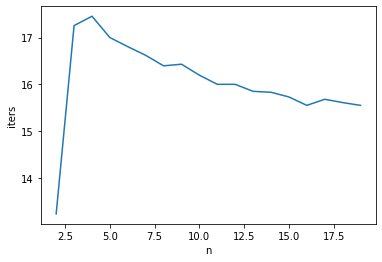

In [15]:


def test_grad():
    n = 5
    res1 = []
    iters = 200
    for k in range(1,10):
        resavg = 0
        for iter in range(iters):
            f, f_grad = gen_fs(n, k)
            res, trace = gradient_descent(
                f, f_grad,
                np.array([-3] * n),
                gold_sech,
                10**-7
            )
            resavg += len(trace)
        res1.append(resavg/iters)
        print("n =", n, " k = ", k, "res = ", res, " iters = ", len(trace))
    k = 5
    plt.plot([i for i in range(1, 10)], res1)
    plt.xlabel('k')
    plt.ylabel('iters')
    plt.show()
    res1 = []
    for n in range(2,20):
        resavg = 0
        for iter in range(iters):
            f, f_grad = gen_fs(n, k)
            res, trace = gradient_descent(
                f, f_grad,
                np.array([-3] * n),
                gold_sech,
                10**-7
            )
            resavg += len(trace)
        res1.append(resavg/iters)
        print("n =", n, " k = ", k, "res = ", res, " iters = ", len(trace))
    plt.plot([i for i in range(2, 20)], res1)
    plt.xlabel('n') 
    plt.ylabel('iters')
    plt.show()
        
test_grad()